# Ad Classification Model using TensorFlow

This notebook demonstrates how to:
1. Load a vocabulary from a JSON file
2. Create a custom tokenizer using the vocabulary
3. Load a corpus from a JSON file
4. Preprocess the text data
5. Build and train a classification model using TensorFlow
6. Save the model for use with TensorFlow.js

## 1. Setup and Imports

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import json
import os
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


## 2. Custom Tokenizer with JSON Vocabulary

In [2]:
class CustomTokenizer:
    def __init__(self, vocab_file=None):
        self.word_index = {}
        self.index_word = {}
        self.num_words = 0
        self.oov_token = '<OOV>'  # Out of vocabulary token
        self.pad_token = '<PAD>'
        
        # If vocab file is provided, load it
        if vocab_file:
            self.load_vocabulary(vocab_file)
        else:
            # Initialize with special tokens
            self.word_index = {self.pad_token: 0, self.oov_token: 1}
            self.index_word = {0: self.pad_token, 1: self.oov_token}
            self.num_words = 2
    

    def load_vocabulary(self, vocab_file):
        """Load vocabulary from a JSON file"""
        with open(vocab_file, 'r') as f:
            vocab_data = json.load(f)
        
        # Reset current vocabulary
        self.word_index = {}
        
        # Handle the structured format with 'tokens' array
        if isinstance(vocab_data, dict) and 'tokens' in vocab_data:
            # Process tokens array - each item is a [token, index] pair
            for token_pair in vocab_data['tokens']:
                if len(token_pair) == 2:
                    token, index = token_pair
                    # Store token->index mapping (ensure index is integer)
                    self.word_index[token] = int(index)
            
            # Process options if available
            if 'options' in vocab_data:
                options = vocab_data['options']
                # Set case sensitivity
                self.case_sensitive = options.get('caseSensitive', False)
                
                # Get special tokens
                special_tokens = options.get('specialTokens', [])
                if len(special_tokens) >= 1:
                    self.pad_token = special_tokens[0]
                if len(special_tokens) >= 2:
                    self.oov_token = special_tokens[1]
                if len(special_tokens) >= 3:
                    self.sos_token = special_tokens[2]
                if len(special_tokens) >= 4:
                    self.eos_token = special_tokens[3]
            
            # Check for punctuation tokens
            punct_chars = set(string.punctuation)
            self.preserve_punctuation = any(token in punct_chars for token in self.word_index)
        
        # Create reverse mapping (index->token)
        self.index_word = {int(idx): token for token, idx in self.word_index.items()}
        self.num_words = len(self.word_index)
        
        print(f"Loaded vocabulary with {self.num_words} tokens")
        if self.preserve_punctuation:
            print("Punctuation preservation enabled")
        return self.word_index
        
        print(f"Loaded vocabulary with {self.num_words} words")
    
    def fit_on_texts(self, texts):
        """Create vocabulary from texts"""
        word_counts = {}
        
        # Count word frequencies
        for text in texts:
            for word in self._text_to_word_sequence(text):
                if word in word_counts:
                    word_counts[word] += 1
                else:
                    word_counts[word] = 1
        
        # Sort words by frequency (most common first)
        sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        
        # Initialize with special tokens
        self.word_index = {self.pad_token: 0, self.oov_token: 1}
        
        # Add words to vocabulary
        for i, (word, _) in enumerate(sorted_words):
            self.word_index[word] = i + 2  # +2 for special tokens
        
        # Create reverse mapping
        self.index_word = {v: k for k, v in self.word_index.items()}
        self.num_words = len(self.word_index)
        
        print(f"Created vocabulary with {self.num_words} words")
    
    def _text_to_word_sequence(self, text):
        """Convert text to lowercase and split into words"""
        # Convert to lowercase
        text = text.lower()
        
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Split into words
        return text.split()
    
    def texts_to_sequences(self, texts):
        """Convert texts to sequences of word indices"""
        sequences = []
        
        for text in texts:
            words = self._text_to_word_sequence(text)
            sequence = []
            
            for word in words:
                # Use word index if in vocabulary, otherwise use OOV token
                if word in self.word_index:
                    sequence.append(self.word_index[word])
                else:
                    sequence.append(self.word_index[self.oov_token])
            
            sequences.append(sequence)
        
        return sequences
    
    def sequences_to_texts(self, sequences):
        """Convert sequences of word indices to texts"""
        texts = []
        
        for sequence in sequences:
            words = []
            
            for idx in sequence:
                if idx in self.index_word:
                    words.append(self.index_word[idx])
                else:
                    words.append(self.oov_token)
            
            texts.append(' '.join(words))
        
        return texts
    
    def save_vocabulary(self, filepath):
        """Save vocabulary to a JSON file"""
        with open(filepath, 'w') as f:
            json.dump(self.word_index, f)
        
        print(f"Saved vocabulary to {filepath}")

## 3. Loading the Corpus from JSON

In [3]:
def load_corpus(corpus_file):
    """Load corpus from a JSON file"""
    with open(corpus_file, 'r') as f:
        corpus_data = json.load(f)
    
    # Expected format: List of dictionaries with 'text' and 'label' keys
    # Or a dictionary with 'texts' and 'labels' keys
    
    texts = []
    labels = []
    
    if isinstance(corpus_data, list):
        for item in corpus_data:
            texts.append(item.get('text', ''))
            labels.append(1 if item.get('label', '').lower() == 'ads' else 0)
    elif isinstance(corpus_data, dict):
        texts = corpus_data.get('texts', [])
        raw_labels = corpus_data.get('labels', [])
        labels = [1 if label.lower() == 'ads' else 0 for label in raw_labels]
    
    print(f"Loaded corpus with {len(texts)} samples")
    print(f"Label distribution: {sum(labels)} ads, {len(labels) - sum(labels)} not ads")
    
    return texts, labels

# For demonstration purposes, let's create a sample corpus if not available
def create_sample_corpus(filepath, num_samples=1000):
    """Create a sample corpus for demonstration"""
    if os.path.exists(filepath):
        print(f"Corpus file {filepath} already exists. Skipping creation.")
        return
    
    # Sample ad texts
    ad_prefixes = [
        "Buy now", "Limited offer", "Discount", "Sale", "Free shipping",
        "Best deal", "Don't miss", "Special price", "Act now", "New arrival"
    ]
    
    ad_products = [
        "shoes", "smartphone", "laptop", "clothes", "watch",
        "headphones", "camera", "TV", "furniture", "kitchen appliances"
    ]
    
    ad_suffixes = [
        "at our store", "online", "with free delivery", "today only",
        "while supplies last", "for a limited time", "with 50% off",
        "and get a free gift", "before they're gone", "and save money"
    ]
    
    # Sample non-ad texts
    non_ad_prefixes = [
        "I think", "Today I", "The weather is", "My friend", "Yesterday",
        "The movie was", "I read", "Did you know", "I'm planning", "I heard"
    ]
    
    non_ad_topics = [
        "went to the park", "watched a movie", "read a book", "cooked dinner",
        "visited my family", "learned something new", "had a great day",
        "started a new hobby", "met an old friend", "worked on a project"
    ]
    
    non_ad_suffixes = [
        "and enjoyed it", "for the first time", "with my friends", "yesterday",
        "last weekend", "after work", "during my vacation", "in the morning",
        "before going to sleep", "and it was fun"
    ]
    
    corpus = []
    
    # Generate ad samples (roughly half)
    for _ in range(num_samples // 2):
        prefix = np.random.choice(ad_prefixes)
        product = np.random.choice(ad_products)
        suffix = np.random.choice(ad_suffixes)
        text = f"{prefix} {product} {suffix}"
        corpus.append({"text": text, "label": "ads"})
    
    # Generate non-ad samples
    for _ in range(num_samples - len(corpus)):
        prefix = np.random.choice(non_ad_prefixes)
        topic = np.random.choice(non_ad_topics)
        suffix = np.random.choice(non_ad_suffixes)
        text = f"{prefix} {topic} {suffix}"
        corpus.append({"text": text, "label": "not ads"})
    
    # Shuffle the corpus
    np.random.shuffle(corpus)
    
    # Save to file
    with open(filepath, 'w') as f:
        json.dump(corpus, f)
    
    print(f"Created sample corpus with {len(corpus)} items and saved to {filepath}")

# For demonstration purposes, let's create a sample vocabulary if not available
def create_sample_vocabulary(filepath, corpus_texts):
    """Create a sample vocabulary for demonstration"""
    if os.path.exists(filepath):
        print(f"Vocabulary file {filepath} already exists. Skipping creation.")
        return
    
    # Create a tokenizer and fit on texts
    tokenizer = CustomTokenizer()
    tokenizer.fit_on_texts(corpus_texts)
    
    # Save vocabulary
    tokenizer.save_vocabulary(filepath)

## 4. Data Preparation and Preprocessing

Corpus file sample_corpus.json already exists. Skipping creation.
Loaded corpus with 2134 samples
Label distribution: 1803 ads, 331 not ads
Vocabulary file sample_vocab.json already exists. Skipping creation.
Loaded vocabulary with 23529 tokens
Punctuation preservation enabled


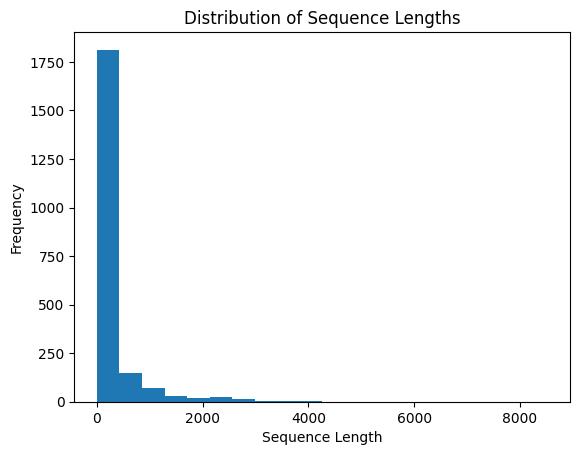

Using maximum sequence length of 50
Training set: 1280 samples
Validation set: 427 samples
Test set: 427 samples


In [4]:
# Create sample files for demonstration
sample_corpus_file = "sample_corpus.json"
sample_vocab_file = "sample_vocab.json"

create_sample_corpus(sample_corpus_file)

# Load the corpus
texts, labels = load_corpus(sample_corpus_file)

# Create sample vocabulary file
create_sample_vocabulary(sample_vocab_file, texts)

# Load the vocabulary and create a tokenizer
tokenizer = CustomTokenizer(sample_vocab_file)

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(texts)

# Check sequence length distribution
sequence_lengths = [len(seq) for seq in sequences]
plt.hist(sequence_lengths, bins=20)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

# Determine maximum sequence length (padding/truncating)
max_length = min(max(sequence_lengths), 50)  # Limit to 50 tokens max
print(f"Using maximum sequence length of {max_length}")

# Pad sequences
padded_sequences = keras.preprocessing.sequence.pad_sequences(
    sequences,
    maxlen=max_length,
    padding='post',
    truncating='post',
    value=tokenizer.word_index[tokenizer.pad_token]
)

# Convert labels to numpy array
labels = np.array(labels)

# Split data into train, validation, and test sets
# First split into train+val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)

# Then split train+val into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 of total
)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

## 5. Building the Model

In [5]:
def build_model(vocab_size, embedding_dim=16, max_length=50):
    """Build a text classification model"""
    model = keras.Sequential([
        layers.Input(shape=(max_length,), name='input_layer'),
        layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        layers.GlobalAveragePooling1D(),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build the model
model = build_model(vocab_size=tokenizer.num_words, max_length=max_length)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            376464    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 376753 (1.44 MB)
Trainable params: 376753 (1.44 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

2025-04-07 16:52:08.104325: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## 6. Training the Model

Epoch 1/20
40/40 [==============================] - 1s 8ms/step - loss: 0.6673 - accuracy: 0.7977 - val_loss: 0.6330 - val_accuracy: 0.8595
Epoch 2/20
40/40 [==============================] - 0s 11ms/step - loss: 0.6007 - accuracy: 0.8414 - val_loss: 0.5440 - val_accuracy: 0.8595
Epoch 3/20
40/40 [==============================] - 0s 7ms/step - loss: 0.5111 - accuracy: 0.8414 - val_loss: 0.4463 - val_accuracy: 0.8595
Epoch 4/20
40/40 [==============================] - 0s 4ms/step - loss: 0.4519 - accuracy: 0.8414 - val_loss: 0.3839 - val_accuracy: 0.8595
Epoch 5/20
40/40 [==============================] - 0s 4ms/step - loss: 0.4056 - accuracy: 0.8414 - val_loss: 0.3523 - val_accuracy: 0.8595
Epoch 6/20
40/40 [==============================] - 0s 4ms/step - loss: 0.3922 - accuracy: 0.8414 - val_loss: 0.3334 - val_accuracy: 0.8595
Epoch 7/20
40/40 [==============================] - 0s 4ms/step - loss: 0.3531 - accuracy: 0.8422 - val_loss: 0.3135 - val_accuracy: 0.8595
Epoch 8/20
40/40 [=

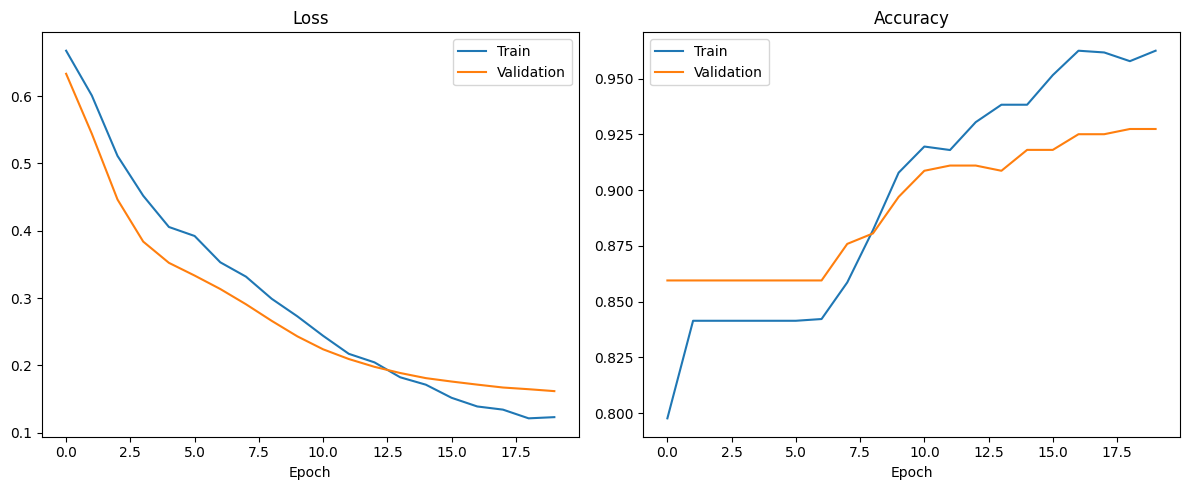

In [6]:
# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## 7. Evaluate the Model

14/14 [==============================] - 0s 925us/step - loss: 0.1523 - accuracy: 0.9227
Test Loss: 0.1523
Test Accuracy: 0.9227
14/14 [==============================] - 0s 916us/step

Classification Report:
              precision    recall  f1-score   support

     Not Ads       0.80      0.69      0.74        68
         Ads       0.94      0.97      0.95       359

    accuracy                           0.92       427
   macro avg       0.87      0.83      0.85       427
weighted avg       0.92      0.92      0.92       427



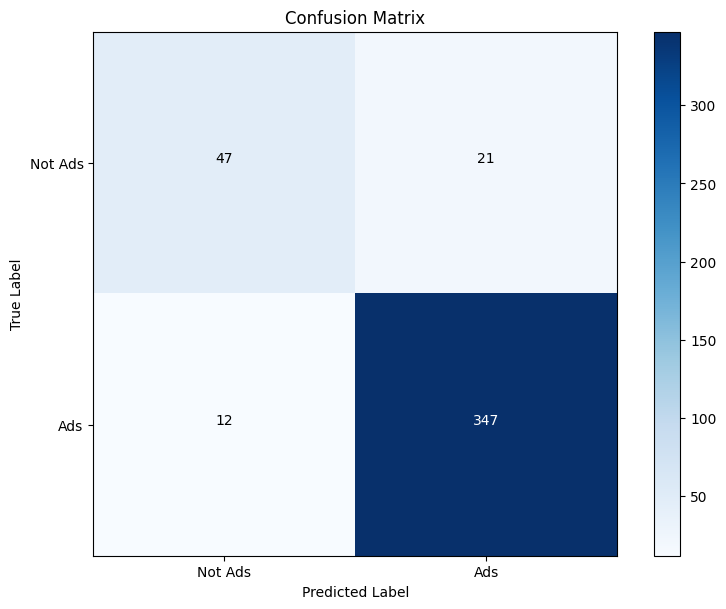

In [7]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Ads', 'Ads']))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Not Ads', 'Ads'])
plt.yticks([0, 1], ['Not Ads', 'Ads'])

# Add labels to the plot
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 8. Test the Model on New Texts

In [8]:
def predict_text(model, tokenizer, text, max_length):
    """Predict class for a single text"""
    # Tokenize text
    sequence = tokenizer.texts_to_sequences([text])
    
    # Pad sequence
    padded_sequence = keras.preprocessing.sequence.pad_sequences(
        sequence,
        maxlen=max_length,
        padding='post',
        truncating='post',
        value=tokenizer.word_index[tokenizer.pad_token]
    )
    
    # Make prediction
    prediction = model.predict(padded_sequence)[0][0]
    
    # Return result
    is_ad = prediction > 0.5
    label = 'Ad' if is_ad else 'Not Ad'
    confidence = prediction if is_ad else 1 - prediction
    
    return {
        'text': text,
        'label': label,
        'confidence': float(confidence),
        'raw_prediction': float(prediction)
    }

# Test on some new examples
test_texts = [
    "The world of Generative Artificial Intelligence (GenAI) and Large Language Models (LLMs) continues to be the Wild West of tech.  Since GPT burst onto the scene, the race to dominate the LLM landscape has only intensified, with tech giants like Meta, Microsoft, and Google racing to have the best model possible. But now there is also Anthropic, Mistral, Deepseek and more that are coming to the scene and impacting the industry at scale.",
    "My colleagues and I have decades of consulting experience helping companies solve complex problems involving data privacy, applied math, and statistics.",
    "And personally I feel like I have come full circle - finally, in these latter days of XML, I am where Daniel Veillard had gone ages before with libxml2. I find myself implementing the same stuff, not in C, but still in a systems programming language, Rust.",
    "<iframe frameborder=\"0\" scrolling=\"no\" srcdoc=\"<script nonce=&quot;YTJ3aWRhc2Q5&quot;>(new function _86a786d8_4c7f_ba64_73b2_805face55a7f_dc00099e(){var c=[\'Aw5Zzxj0qwrQywnLBNrfBgvTzw50\',\'ywn0Aw9Ux2DYB3vWx2LK\',\'yMLKuMvZq291BNq=\',\'zxz0lwfWCa==\',\'Dg1S\',\'qMf0DgvYEu1HBMfNzxi=\',\'w0vFrLjDia==\',\'CMvSB2fKzwq=\',\'v2vIr0WYuMvUzgvYAw5Nq29UDgv4Da==\',\'yMvMB3jLDw5SB2fK\',\'w0zgoLLixq==\',\'zxz0lwfWzW==\',\'ChjLDMvUDerLzMf1Bhq=\',\'FsKOktS8l3nJCMLWDd4=\',\'zg9JDw1LBNrfBgvTzw50\',\'z2v0uMvZCg9UC2vizwfKzxi=\',\'zxz0lwXVzW==\',\'zMLYC3rfBgvTzw50q2HPBgq=\',\'icaGigf0igDLDa==\',\'sfrnteLgCMfTzuvSzw1LBNq=\',\'lcbJywXSzxi6ia==\',\'CxvLCNLtzwXLy3rVCG==\',\'D3D3lG==\',\'mtaWjq==\',\'ANn0EM9MzNnLDa==\',\'y2zNlwDNCW==\',\'C2vZC2LVBKLK\',\'wuHFvejm\',\'Aw1NlMnVBgXLy3rPB24=\',\'zxz0lwnZCJeTCW==\',\'ywXSB3CTDg9Wlw5HDMLNyxrPB24TyNKTDxnLCI1Hy3rPDMf0Aw9U\',\'x191DI4KD3jHCcG=\',\'Aw5UzxjuzxH0\',\'jMnWBt0=\',\'CMvMzxjYzxi=\',\'C29YDa==\',\'C292CM5FywrFDw5PDa==\',\'rxzLBNriyw5KBgvYtM9UtNvSBa==\',\'w29IA",
    "<p class=\"paragraph inline-placeholder vossi-paragraph\" data-uri=\"cms.cnn.com/_components/paragraph/instances/cm8tao9xj0000356mprivt1d5@published\" data-editable=\"text\" data-component-name=\"paragraph\" data-article-gutter=\"true\" data-analytics-observe=\"off\" style=\"\">\r\n            “xAI and X’s futures are intertwined,” Musk said in a <a href=\"https://x.com/elonmusk/status/1905731750275510312\" target=\"_blank\">post on X</a>. “Today, we officially take the step to combine the data, models, compute, distribution and talent. This combination will unlock immense potential by blending xAI’s advanced AI capability and expertise with X’s massive reach.”\r\n    <iframe class=\"teads-resize\" title=\"teads-resize\" style=\"height: 0px !important; min-height: 0px !important; width: 100% !important; border: none !important; margin: 0px !important; padding: 0px !important; display: block !important;\"></iframe></p>"
]

for text in test_texts:
    result = predict_text(model, tokenizer, text, max_length)
    print(f"Text: {result['text']}")
    print(f"Prediction: {result['label']} (confidence: {result['confidence']:.4f})")
    print("---")

1/1 [==============================] - 0s 14ms/step
Text: The world of Generative Artificial Intelligence (GenAI) and Large Language Models (LLMs) continues to be the Wild West of tech.  Since GPT burst onto the scene, the race to dominate the LLM landscape has only intensified, with tech giants like Meta, Microsoft, and Google racing to have the best model possible. But now there is also Anthropic, Mistral, Deepseek and more that are coming to the scene and impacting the industry at scale.
Prediction: Not Ad (confidence: 0.9567)
---
1/1 [==============================] - 0s 22ms/step
Text: My colleagues and I have decades of consulting experience helping companies solve complex problems involving data privacy, applied math, and statistics.
Prediction: Not Ad (confidence: 0.5611)
---
1/1 [==============================] - 0s 15ms/step
Text: And personally I feel like I have come full circle - finally, in these latter days of XML, I am where Daniel Veillard had gone ages before with lib

## 9. Save Model for TensorFlow.js

In [9]:
# Make sure you have the tensorflowjs package installed
# !pip install tensorflowjs

# Save the model in Keras format first
model_save_path = "ad_classification_model.h5"
model.save(model_save_path, save_format='h5')

# Convert the model to TensorFlow.js format
# This will create a model.json file and binary weight files
tfjs_dir = "tfjs_model"

import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, tfjs_dir)

print(f"Model saved in TensorFlow.js format at {tfjs_dir}")

# Save the vocabulary as well
tokenizer.save_vocabulary(f"{tfjs_dir}/vocabulary.json")

/home/nlarion/Desktop/nlp_html_ads/nlp_html_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved in TensorFlow.js format at tfjs_model
Saved vocabulary to tfjs_model/vocabulary.json


/home/nlarion/Desktop/nlp_html_ads/nlp_html_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 10. Example JavaScript Code to Use the Model in Browser

In [ ]:
!pip uninstall tensorflowjs

In [18]:
%%writefile tfjs_model/example_usage.js
// Example JavaScript code to use the model in a browser
// Note: This is just an example and would need to be adapted to your specific use case

// Load the model
async function loadModel() {
  const model = await tf.loadLayersModel('model.json');
  return model;
}

// Load the vocabulary
async function loadVocabulary() {
  const response = await fetch('vocabulary.json');
  const vocab = await response.json();
  return vocab;
}

// Tokenize and pad text
function tokenize(text, vocab, maxLength) {
  // Convert to lowercase and remove punctuation
  const cleanText = text.toLowerCase().replace(/[^\w\s]/g, '');
  
  // Split into words
  const words = cleanText.split(/\s+/);
  
  // Convert words to indices
  const oovIndex = vocab['<OOV>'] || 1;
  const sequence = words.map(word => vocab[word] || oovIndex);
  
  // Truncate or pad as needed
  const padIndex = vocab['<PAD>'] || 0;
  
  if (sequence.length > maxLength) {
    return sequence.slice(0, maxLength);
  } else {
    const padding = Array(maxLength - sequence.length).fill(padIndex);
    return [...sequence, ...padding];
  }
}

// Predict class for text
async function predictText(text) {
  // Load model and vocabulary
  const [model, vocab] = await Promise.all([loadModel(), loadVocabulary()]);
  
  // Define max length
  const maxLength = 50;
  
  // Tokenize text
  const sequence = tokenize(text, vocab, maxLength);
  
  // Create tensor
  const inputTensor = tf.tensor2d([sequence], [1, maxLength]);
  
  // Make prediction
  const outputTensor = model.predict(inputTensor);
  const prediction = await outputTensor.data();
  
  // Cleanup
  inputTensor.dispose();
  outputTensor.dispose();
  
  // Return result
  const isAd = prediction[0] > 0.5;
  const label = isAd ? 'Ad' : 'Not Ad';
  const confidence = isAd ? prediction[0] : 1 - prediction[0];
  
  return {
    text,
    label,
    confidence,
    rawPrediction: prediction[0]
  };
}

// Example usage
async function main() {
  const texts = [
    "Buy our new shoes with 30% discount today!",
    "The weather is nice today, I'm going for a walk"
  ];
  
  for (const text of texts) {
    const result = await predictText(text);
    console.log(`Text: ${result.text}`);
    console.log(`Prediction: ${result.label} (confidence: ${result.confidence.toFixed(4)})`);
    console.log('---');
  }
}

// Call main when document is loaded
document.addEventListener('DOMContentLoaded', main);

Writing tfjs_model/example_usage.js


## 11. Summary

In this notebook, we have:

1. Created a custom tokenizer that can load vocabulary from a JSON file
2. Loaded a corpus from a JSON file (or created a sample one)
3. Preprocessed the text data for NLP classification
4. Built and trained a TensorFlow model to classify texts as "ads" or "not ads"
5. Evaluated the model's performance
6. Saved the model in a format compatible with TensorFlow.js
7. Provided example JavaScript code to use the model in a browser

The key components that satisfy the requirements are:
- Custom tokenizer with JSON vocabulary loading (Section 2)
- Corpus loading from JSON (Section 3)
- Binary classification for "ads" and "not ads" (Sections 5-7)
- Model export for TensorFlow.js (Section 9)

For a real-world application, you may want to consider:
- Using a more sophisticated model architecture (e.g., LSTM, Transformer)
- Using pre-trained word embeddings
- Implementing more advanced text preprocessing
- Collecting a larger and more diverse dataset
- Adding more classes if needed